In [1]:
%load_ext jupyter_black

import notebooks_path

notebooks_path.include_packages()
import jax.numpy as jnp
from vit import dataloader, util

In [2]:
batch_size = 8

In [3]:
train_dataloader = dataloader.get_train_dataloader(batch_size)
test_datalodeer = dataloader.get_test_dataloader(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
image = next(iter(test_datalodeer))

In [5]:
jax_image = jnp.array(image[0][0].numpy())
print(jax_image.shape)

(3, 32, 32)


In [9]:
patches = util.img_to_patches(jax_image, patch_size=16, flatten_channel=False)

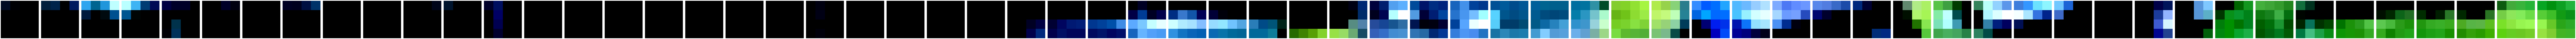

In [10]:
util.plot_patches(patches)